In [15]:

import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
#data path
import pandas as pd
# Import numpy for numerical operations (though mostly used implicitly by pandas here)
import numpy as np
# Import datetime class from datetime module to handle date and time objects
from datetime import datetime
# Import re module for regular expression operations (used for text cleaning)
import re
# Import DATA_PATHS dictionary from the local config module
project_root = r"C:\Users\user\Desktop\Project\Mobile-Banking\src"
if project_root not in sys.path:
    sys.path.append(project_root)
# Now we can safely import config
from config import DATA_PATHS
class ReviewPreprocessor:
    def __init__(self, input_path=None, output_path=None):

        # Set the input path: use the provided argument, or default to DATA_PATHS['raw_reviews'] from config
        self.input_path = input_path or DATA_PATHS['raw_reviews']
        # Set the output path: use the provided argument, or default to DATA_PATHS['processed_reviews'] from config
        self.output_path = output_path or DATA_PATHS['processed_reviews']
        # Initialize an empty DataFrame attribute to hold our data
        self.df = None
        # Initialize a dictionary to keep track of processing statistics (counts, errors, etc.)
        self.stats = {}

    def load_data(self):
        """Load raw reviews data"""
        # Print a message indicating that data loading has started
        print("Loading raw data...")
        try:
            # Read the CSV file at self.input_path into a pandas DataFrame
            self.df = pd.read_csv(self.input_path)
            # Print the number of records loaded
            print(f"Loaded {len(self.df)} reviews")
            # Record the initial number of records in our stats dictionary
            self.stats['original_count'] = len(self.df)
            # Return True to indicate success
            return True
        except FileNotFoundError:
            # Handle the specific error where the file does not exist
            print(f"ERROR: File not found: {self.input_path}")
            # Return False to indicate failure
            return False
        except Exception as e:
            # Handle any other general errors that occur during loading
            print(f"ERROR: Failed to load data: {str(e)}")
            # Return False to indicate failure
            return False

    def check_missing_data(self):
        """Check for missing data"""
        # Print a header for this step [1/6]
        print("\n[1/6] Checking for missing data...")

        # Calculate the count of missing (null) values for each column
        missing = self.df.isnull().sum()
        # Calculate the percentage of missing values for each column
        missing_pct = (missing / len(self.df)) * 100

        # Print the section header
        print("\nMissing values:")
        # Loop through each column name in the index of the 'missing' series
        for col in missing.index:
            # If the column has at least one missing value
            if missing[col] > 0:
                # Print the column name, count of missing values, and percentage
                print(f"  {col}: {missing[col]} ({missing_pct[col]:.2f}%)")

        # Store the dictionary of missing counts in our stats for reporting later
        self.stats['missing_before'] = missing.to_dict()

        # Define a list of columns that are absolutely required for our analysis
        critical_cols = ['review_text', 'rating', 'bank_name']
        # Calculate missing values just for these critical columns
        missing_critical = self.df[critical_cols].isnull().sum()

        # If there are any missing values in critical columns
        if missing_critical.sum() > 0:
            # Print a warning message
            print("\nWARNING: Missing values in critical columns:")
            # Print the counts of missing values for the critical columns that have them
            print(missing_critical[missing_critical > 0])

    def handle_missing_values(self):
        """Handle missing values"""
        # Print a header for this step [2/6]
        print("\n[2/6] Handling missing values...")

        # Define the critical columns again
        critical_cols = ['review_text', 'rating', 'bank_name']
        # Store the count before dropping rows
        before_count = len(self.df)
        # Drop any rows that have missing values (NaN) in the critical columns
        self.df = self.df.dropna(subset=critical_cols)
        # Calculate how many rows were removed
        removed = before_count - len(self.df)

        # If any rows were removed, print a message
        if removed > 0:
            print(f"Removed {removed} rows with missing critical values")

        # For the 'user_name' column, fill missing values with the string 'Anonymous'
        self.df['user_name'] = self.df['user_name'].fillna('Anonymous')
        # For the 'thumbs_up' column, fill missing values with 0
        self.df['thumbs_up'] = self.df['thumbs_up'].fillna(0)
        # For the 'reply_content' column, fill missing values with an empty string
        self.df['reply_content'] = self.df['reply_content'].fillna('')

        # Record the number of rows removed due to missing critical data
        self.stats['rows_removed_missing'] = removed
        # Record the new total count in stats
        self.stats['count_after_missing'] = len(self.df)

    def normalize_dates(self):
        """Normalize date formats to YYYY-MM-DD"""
        # Print a header for this step [3/6]
        print("\n[3/6] Normalizing dates...")

        try:
            # Convert the 'review_date' column to pandas datetime objects
            # This handles various string formats automatically
            self.df['review_date'] = pd.to_datetime(self.df['review_date'])

            # Convert the datetime objects to just date objects (YYYY-MM-DD), removing time info
            self.df['review_date'] = self.df['review_date'].dt.date

            # Extract the year from the date and create a new 'review_year' column
            self.df['review_year'] = pd.to_datetime(self.df['review_date']).dt.year
            # Extract the month from the date and create a new 'review_month' column
            self.df['review_month'] = pd.to_datetime(self.df['review_date']).dt.month

            # Print the range of dates found in the data (minimum and maximum)
            print(f"Date range: {self.df['review_date'].min()} to {self.df['review_date'].max()}")

        except Exception as e:
            # Handle errors if date conversion fails
            print(f"WARNING: Error normalizing dates: {str(e)}")

    def clean_text(self):
        """Clean review text"""
        # Print a header for this step [4/6]
        print("\n[4/6] Cleaning text...")

        def clean_review_text(text):
            """Inner function to clean individual review text strings"""
            # If the text is NaN (missing) or empty string, return empty string
            if pd.isna(text) or text == '':
                return ''

            # Convert the input to a string type (safety check)
            text = str(text)

            # Use regex to replace multiple whitespace characters (spaces, tabs, newlines) with a single space
            text = re.sub(r'\s+', ' ', text)

            # Remove leading and trailing whitespace from the string
            text = text.strip()

            # Return the cleaned text
            return text

        # Apply the 'clean_review_text' function to every element in the 'review_text' column
        self.df['review_text'] = self.df['review_text'].apply(clean_review_text)

        # Store the count before removing empty reviews
        before_count = len(self.df)
        # Keep only rows where the length of 'review_text' is greater than 0
        self.df = self.df[self.df['review_text'].str.len() > 0]
        # Calculate how many empty reviews were removed
        removed = before_count - len(self.df)

        # If rows were removed, print a message
        if removed > 0:
            print(f"Removed {removed} reviews with empty text")

        # Create a new column 'text_length' containing the character count of the review text
        self.df['text_length'] = self.df['review_text'].str.len()

        # Record statistics about text cleaning
        self.stats['empty_reviews_removed'] = removed
        self.stats['count_after_cleaning'] = len(self.df)

    def validate_ratings(self):
        """Validate rating values (should be 1-5)"""
        # Print a header for this step [5/6]
        print("\n[5/6] Validating ratings...")

        # Find rows where 'rating' is less than 1 OR greater than 5
        invalid = self.df[(self.df['rating'] < 1) | (self.df['rating'] > 5)]

        # If there are any invalid ratings
        if len(invalid) > 0:
            # Print a warning with the count of invalid ratings
            print(f"WARNING: Found {len(invalid)} reviews with invalid ratings")
            # Filter the DataFrame to keep only rows where rating is between 1 and 5 (inclusive)
            self.df = self.df[(self.df['rating'] >= 1) & (self.df['rating'] <= 5)]
        else:
            # If all ratings are valid, print a confirmation
            print("All ratings are valid (1-5)")

        # Record the number of invalid ratings removed
        self.stats['invalid_ratings_removed'] = len(invalid)

    def prepare_final_output(self):
        """Prepare final output format"""
        # Print a header for this step [6/6]
        print("\n[6/6] Preparing final output...")

        # Define a list of columns in the desired order for the final output file
        output_columns = [
            'review_id',
            'review_text',
            'rating',
            'review_date',
            'review_year',
            'review_month',
            'bank_code',
            'bank_name',
            'user_name',
            'thumbs_up',
            'text_length',
            'source'
        ]

        # Filter the list to include only columns that actually exist in our DataFrame
        # This prevents errors if a column was missed in previous steps
        output_columns = [col for col in output_columns if col in self.df.columns]
        # Reorder the DataFrame columns according to our list
        self.df = self.df[output_columns]

        # Sort the DataFrame first by 'bank_code' (ascending) and then by 'review_date' (descending/newest first)
        self.df = self.df.sort_values(['bank_code', 'review_date'], ascending=[True, False])

        # Reset the index of the DataFrame so it starts from 0 to N-1 cleanly
        # drop=True prevents the old index from being added as a new column
        self.df = self.df.reset_index(drop=True)

        # Print the final count of reviews
        print(f"Final dataset: {len(self.df)} reviews")

    def save_data(self):
        """Save processed data"""
        # Print a message indicating saving has started
        print("\nSaving processed data...")

        try:
            # Create the directory for the output file if it doesn't already exist
            # os.path.dirname gets the folder part of the file path
            os.makedirs(os.path.dirname(self.output_path), exist_ok=True)

            # Write the DataFrame to a CSV file at self.output_path
            # index=False prevents writing the row numbers (0, 1, 2...) to the file
            self.df.to_csv(self.output_path, index=False)
            # Print a confirmation message with the path
            print(f"Data saved to: {self.output_path}")

            # Record the final count in stats
            self.stats['final_count'] = len(self.df)
            # Return True to indicate success
            return True

        except Exception as e:
            # Handle any errors during saving
            print(f"ERROR: Failed to save data: {str(e)}")
            # Return False to indicate failure
            return False

    def generate_report(self):
        """Generate preprocessing report"""
        # Print a separator line
        print("\n" + "=" * 60)
        # Print the report title
        print("PREPROCESSING REPORT")
        # Print a separator line
        print("=" * 60)

        # Print various statistics gathered during the process using .get() to avoid errors if key is missing
        print(f"\nOriginal records: {self.stats.get('original_count', 0)}")
        print(f"Records with missing critical data: {self.stats.get('rows_removed_missing', 0)}")
        print(f"Empty reviews removed: {self.stats.get('empty_reviews_removed', 0)}")
        print(f"Invalid ratings removed: {self.stats.get('invalid_ratings_removed', 0)}")
        print(f"Final records: {self.stats.get('final_count', 0)}")

        # Calculate data quality percentage metrics
        if self.stats.get('original_count', 0) > 0:
            # Retention rate = (Final / Original) * 100
            # We use .get(..., 1) for denominator to avoid division by zero if original_count is missing
            retention_rate = (self.stats.get('final_count', 0) / self.stats.get('original_count', 1)) * 100
            # Error rate is the inverse of retention rate
            error_rate = 100 - retention_rate
            print(f"\nData retention rate: {retention_rate:.2f}%")
            print(f"Data error rate: {error_rate:.2f}%")

            # Assess quality based on error rate thresholds
            if error_rate < 5:
                print("✓ Data quality: EXCELLENT (<5% errors)")
            elif error_rate < 10:
                print("✓ Data quality: GOOD (<10% errors)")
            else:
                print("⚠ Data quality: NEEDS ATTENTION (>10% errors)")

        # Print statistics about the reviews per bank
        if self.df is not None:
            print("\nReviews per bank:")
            # Count occurrences of each unique value in 'bank_name'
            bank_counts = self.df['bank_name'].value_counts()
            # Loop through the results and print them
            for bank, count in bank_counts.items():
                print(f"  {bank}: {count}")

            # Print statistics about rating distribution
            print("\nRating distribution:")
            # Count occurrences of each rating, and sort by rating (5 down to 1)
            rating_counts = self.df['rating'].value_counts().sort_index(ascending=False)
            for rating, count in rating_counts.items():
                # Calculate percentage for this rating
                pct = (count / len(self.df)) * 100
                # Print star representation, count, and percentage
                print(f"  {'⭐' * int(rating)}: {count} ({pct:.1f}%)")

            # Print the full date range of the data
            print(f"\nDate range: {self.df['review_date'].min()} to {self.df['review_date'].max()}")

            # Print statistics about the length of the review texts
            print(f"\nText statistics:")
            print(f"  Average length: {self.df['text_length'].mean():.0f} characters")
            print(f"  Median length: {self.df['text_length'].median():.0f} characters")
            print(f"  Min length: {self.df['text_length'].min()}")
            print(f"  Max length: {self.df['text_length'].max()}")

    def process(self):
        print("=" * 60)
        print("STARTING DATA PREPROCESSING")
        print("=" * 60)
        if not self.load_data():
            return False
        self.check_missing_data()
        self.handle_missing_values()
        self.normalize_dates()
        self.clean_text()
        self.validate_ratings()
        self.prepare_final_output()

        # Attempt to save the data. If successful, generate the report.
        if self.save_data():
            self.generate_report()
            return True

        # If saving failed, return False
        return False


def main():
    """Main execution function"""
    # Create an instance of the ReviewPreprocessor class
    preprocessor = ReviewPreprocessor()
    # Run the processing pipeline
    success = preprocessor.process()

    # Check if the process was successful
    if success:
        print("\n✓ Preprocessing completed successfully!")
        # Return the processed DataFrame
        return preprocessor.df
    else:
        print("\n✗ Preprocessing failed!")
        # Return None to indicate failure
        return None
if __name__ == "__main__":
    # If run directly, execute the main function
    processed_df = main()


STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1200 reviews

[1/6] Checking for missing data...

Missing values:
  reply_content: 1200 (100.00%)

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2023-03-29 to 2025-11-28

[4/6] Cleaning text...

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 1200 reviews

Saving processed data...
Data saved to: C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\reviews_processed.csv

PREPROCESSING REPORT

Original records: 1200
Records with missing critical data: 0
Empty reviews removed: 0
Invalid ratings removed: 0
Final records: 1200

Data retention rate: 100.00%
Data error rate: 0.00%
✓ Data quality: EXCELLENT (<5% errors)

Reviews per bank:
  Abyssinia Bank: 400
  Commercial Bank of Ethiopia: 400
  Dashen Bank: 400

Rating distribution:
  ⭐⭐⭐⭐⭐: 727 (60.6%)
  ⭐⭐⭐⭐: 101 (8.4%)
  ⭐⭐⭐: 75 (6.2%)
  ⭐⭐: 43 (3.6%)
  ⭐: 254 (21.2%)

Date range: 2023-03-29 to 2

# All Banks Review and Save in Csv

In [ ]:

from google_play_scraper import Sort, reviews_all
# Mapping of app packages to bank codes and names
bank_mapping = {
    "com.cr2.amolelight": {"bank_code": "DASHEN", "bank_name": "Dashen Bank"},
    "com.combanketh.mobilebanking": {"bank_code": "CBE", "bank_name": "Commercial Bank of Ethiopia"},
    "com.boa.boaMobileBanking": {"bank_code": "BOA", "bank_name": "Abyssinia Bank"}
}

bank_apps = list(bank_mapping.keys())
all_dfs = []

def run_scraper(app_package, max_reviews=400):
    """
    Scrape reviews for a single app package using google_play_scraper
    """
    print(f"\n🔍 Scraping reviews for {app_package} ...")
    try:
        data = reviews_all(
            app_package,
            sleep_milliseconds=0,
            lang="en",
            country="us",
            sort=Sort.NEWEST
        )

        df = pd.DataFrame(data)

        if df.empty:
            print(f"⚠ No reviews found for {app_package}")
            return pd.DataFrame()

        # Keep only relevant columns
        df = df[["userName", "content", "score", "at"]]

        return df[:max_reviews]

    except Exception as e:
        print(f"❌ Error scraping {app_package}: {e}")
        return pd.DataFrame()


print("🚀 Starting Scraper for 3 banks...")

for app in bank_apps:
    df = run_scraper(app_package=app, max_reviews=400)

    # If scraper returns empty, create an empty DataFrame with expected columns
    if df.empty:
        df = pd.DataFrame(columns=["userName", "content", "score", "at"])

    # Map bank info
    df["bank_code"] = bank_mapping[app]["bank_code"]
    df["bank_name"] = bank_mapping[app]["bank_name"]

    # Rename columns to match desired output
    df = df.rename(columns={
        "userName": "user_name",
        "content": "review_text",
        "score": "rating",
        "at": "review_date"
    })

    # Add missing columns with default values
    if "thumbs_up" not in df.columns:
        df["thumbs_up"] = 0
    if "reply_content" not in df.columns:
        df["reply_content"] = ""
    df["source"] = "PlayStore"

    # Add review_id
    df = df.reset_index().rename(columns={"index": "review_id"})
    df["review_id"] += 1  # Start IDs from 1

    all_dfs.append(df)

# Combine all bank reviews
combined_df = pd.concat(all_dfs, ignore_index=True)

# Reorder columns to match CSV format
combined_df = combined_df[[
    "review_id",
    "review_text",
    "rating",
    "review_date",
    "bank_code",
    "bank_name",
    "user_name",
    "thumbs_up",
    "reply_content",
    "source"
]]

# Ensure output folder exists
output_path = r"C:\Users\user\Desktop\Project\Mobile-Banking\data\raw"
os.makedirs(output_path, exist_ok=True)

# Save to CSV
output_file = os.path.join(output_path, "reviews_raw.csv")
combined_df.to_csv(output_file, index=False)

print("\n✅ Scraping Finished for all 3 banks.")
print(f"CSV file saved at: {output_file}")

# Display first 10 rows
display(combined_df.head(10))


🚀 Starting Scraper for 3 banks...

🔍 Scraping reviews for com.cr2.amolelight ...

🔍 Scraping reviews for com.combanketh.mobilebanking ...

🔍 Scraping reviews for com.boa.boaMobileBanking ...

✅ Scraping Finished for all 3 banks.
CSV file saved at: C:\Users\user\Desktop\Project\Mobile-Banking\data\raw\reviews_raw.csv


,review_id,review_text,rating,review_date,bank_code,bank_name,user_name,thumbs_up,reply_content,source
0,1,Very disappointing application. it's getting w...,1,2025-10-31 19:25:05,DASHEN,Dashen Bank,A.Senay ZENEBE,0,,PlayStore
1,2,"Banking made simple, smart, and safe.",5,2025-10-28 15:35:23,DASHEN,Dashen Bank,Bilen Atinafe,0,,PlayStore
2,3,It is the best of all i liked it i used it alm...,5,2025-10-27 19:37:55,DASHEN,Dashen Bank,Guta Gundo,0,,PlayStore
3,4,gngu,5,2025-10-21 00:31:58,DASHEN,Dashen Bank,Yalelet Ahmed,0,,PlayStore
4,5,"The app is very good , but it does not tell th...",4,2025-09-09 22:24:44,DASHEN,Dashen Bank,Esrael Worku,0,,PlayStore
5,6,The best app and easy to use. The only draw ba...,3,2025-08-24 19:32:32,DASHEN,Dashen Bank,Yalelet,0,,PlayStore
6,7,Please enable the app for sreen shoot,1,2025-08-19 00:21:56,DASHEN,Dashen Bank,MILKIAS KETEMA,0,,PlayStore
7,8,good,3,2025-08-11 16:57:40,DASHEN,Dashen Bank,Teka Gebere,0,,PlayStore
8,9,good,4,2025-08-08 14:37:50,DASHEN,Dashen Bank,Omer Seid,0,,PlayStore
9,10,the best mobile banking app in Ethiopia,5,2025-07-19 15:31:07,DASHEN,Dashen Bank,ENZO FERNANDEZ,0,,PlayStore


# Run Preprocessing Pipeline

In [11]:
# Initialize the preprocessor
from preprocessing import ReviewPreprocessor
preprocessor = ReviewPreprocessor()
# Run the process
success = preprocessor.process()
if success:
    print("\n✅ Preprocessing finished successfully!")
    df = preprocessor.df
else:
    print("❌ Preprocessing failed.")

STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1200 reviews

[1/6] Checking for missing data...

Missing values:
  reply_content: 1200 (100.00%)

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2023-03-29 to 2025-11-28

[4/6] Cleaning text...

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 1200 reviews

Saving processed data...
Data saved to: C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\reviews_processed.csv

PREPROCESSING REPORT

Original records: 1200
Records with missing critical data: 0
Empty reviews removed: 0
Invalid ratings removed: 0
Final records: 1200

Data retention rate: 100.00%
Data error rate: 0.00%
✓ Data quality: EXCELLENT (<5% errors)

Reviews per bank:
  Abyssinia Bank: 400
  Commercial Bank of Ethiopia: 400
  Dashen Bank: 400

Rating distribution:
  ⭐⭐⭐⭐⭐: 727 (60.6%)
  ⭐⭐⭐⭐: 101 (8.4%)
  ⭐⭐⭐: 75 (6.2%)
  ⭐⭐: 43 (3.6%)
  ⭐: 254 (21.2%)

Date range: 2023-03-29 to 2

# Visualizations

C:\Users\user\AppData\Local\Temp\ipykernel_13860\3931391577.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_13860\3931391577.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bank_code', data=df, palette='Set2')


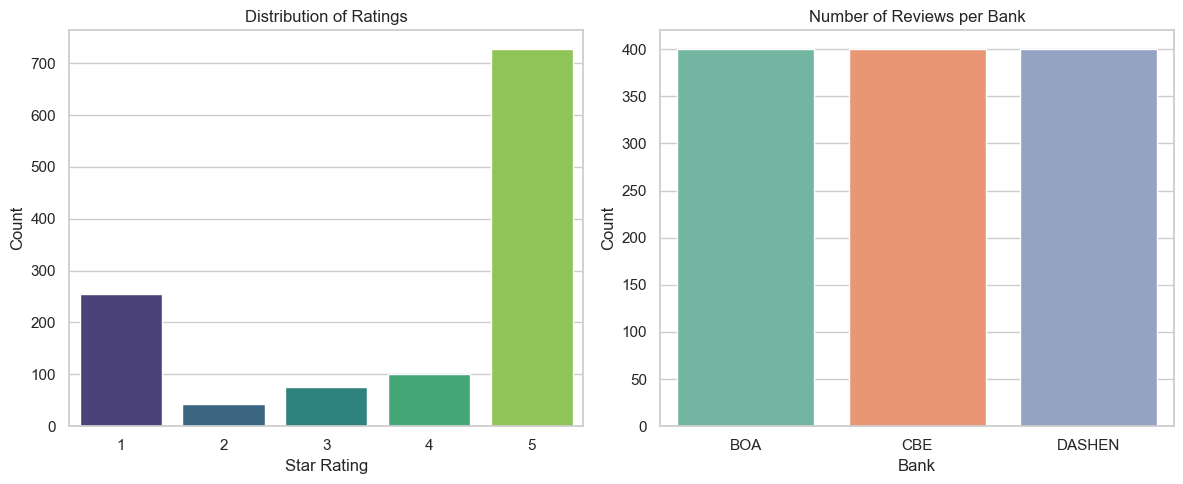

In [16]:

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))
# 1. Ratings Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')

# 2. Reviews per Bank
plt.subplot(1, 2, 2)
sns.countplot(x='bank_code', data=df, palette='Set2')
plt.title('Number of Reviews per Bank')
plt.xlabel('Bank')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Review Length Distribution

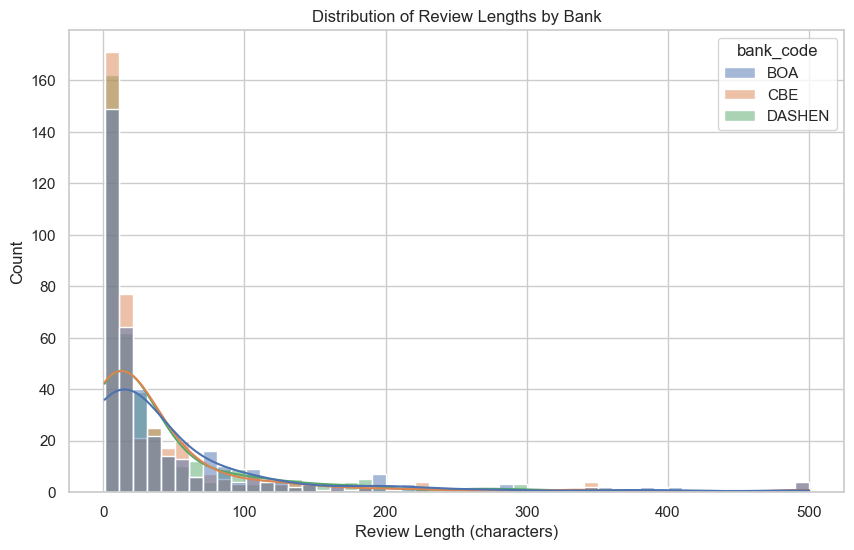

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50, kde=True, hue='bank_code')
plt.title('Distribution of Review Lengths by Bank')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()